### Bayesian Matrix Factorization

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
%matplotlib inline

### Toy data generation

In [2]:
np.random.seed(42)

# Number of rows
L = 200
# Number of columns
M = 300
# Number of true hidden dimensions
H_ = 20 

In [3]:
# variance value for matrix A features
c_a = 10
# Set mean and covariance
mu_a = np.zeros(H_)
cov_a = c_a*np.eye(H_)
# Draw matrix A
A_ = rnd.multivariate_normal(mu_a, cov_a, size = M)
A_.shape, A_.var(0)

((300, 20),
 array([ 9.04961743, 10.3590825 , 10.4791307 ,  9.3342627 , 10.38924473,
        10.43505176, 10.25384223,  9.94180516,  8.45868375,  9.5129113 ,
         9.1728604 , 11.58040925,  8.7595023 , 10.12451662, 10.42922374,
        11.39614155, 10.50007971, 10.6035817 ,  9.32842362,  8.73981345]))

In [4]:
# variance value for matrix B features
c_b = 5
# Set mean and covariance
mu_b = np.zeros(H_)
cov_b = c_b*np.eye(H_)
# Draw matrix B
B_ = rnd.multivariate_normal(mu_b, cov_b, size = L)
B_.shape, B_.var(0)

((200, 20), array([6.05240214, 4.29656712, 4.79860874, 5.00501828, 5.12393624,
        5.22251173, 5.21014146, 5.27408902, 5.12683731, 3.94778469,
        5.42757565, 5.00618059, 4.85111056, 4.49695536, 4.86032671,
        5.13743426, 5.62505817, 5.83731213, 5.83549215, 4.62177007]))

In [5]:
X = B_ @ A_.T # shape -> (M,N)
X.shape, la.matrix_rank(X)

((200, 300), 20)

In [6]:
# Adding some gaussian noise
sigma = 4
X += rnd.normal(0,sigma,size=(L,M))
# rank becomes min(H,M)
la.matrix_rank(X)

200

### Singular Value Decomposition
<br>
<center>
    $\boxed{\large{
    \Omega_L,\Sigma,\Omega_R = \text{svd}(V)
    }}$

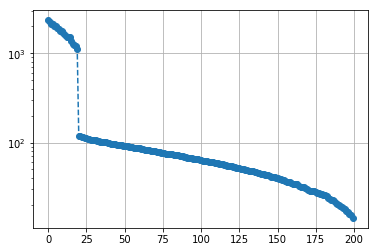

In [9]:
import matplotlib.pyplot as plt

# 200,200, 200   200,300
Left,      S,    Right = la.svd(X, full_matrices=False)

X_hat = Left @ np.diag(S) @ Right 

assert np.allclose( X , X_hat)
plt.figure(figsize = (6,4))
plt.plot(np.arange(len(S)),S,'o--')
plt.yscale('log')
plt.grid()
plt.show()

### Variational Bayesian Matrix Factorization Model

<img src="VMF.png" width=500/>

### Initialize A, B, Sigma_A, Sigma_B, C_A, C_B

In [11]:
H = min(X.shape)

C_A = np.eye(H)
C_B = np.copy(C_A)

Sigma_A = np.copy(C_A)
Sigma_B = np.copy(C_B)

A = rnd.normal(0,1,size = (M,H))
B = rnd.normal(0,1,size = (L,H))

#Init sigma as normalized squared Frobenius norm of the data

sigma2 = la.norm(X)**2/(L*M)
sigma2

1035.4253648806991

<center>
    $\boxed{\large{
    \hat{\Sigma}_A = \sigma^2\Big( \hat{B}^{\top}\hat{B} + L\hat\Sigma_B + \sigma^2C_A^{-1}\Big)^{-1}
    }}
    $

In [12]:
def update_Sigma_A():
    Sigma_A = sigma2*la.inv(B.T @ B + L*Sigma_B + sigma2*np.linalg.inv(C_A))
    return Sigma_A
update_Sigma_A().shape

(200, 200)

<center>
    $\boxed{\large{
    \hat{A} = X^{\top}\hat{B}\frac{\hat{\Sigma}_{A}}{\sigma^2}
    }}$

In [14]:
def update_A():
    A = X.T @ B @ Sigma_A/sigma2
    return A
update_A().shape

(300, 200)

<center>
    $\boxed{\large{
    \hat{\Sigma}_B = \sigma^2\Big( \hat{A}^{\top}\hat{A} + M\hat\Sigma_A + \sigma^2C_B^{-1}\Big)^{-1}
    }}
    $

In [15]:
def update_Sigma_B():
    Sigma_B = sigma2*la.inv(A.T @ A + M*Sigma_A + sigma2*np.linalg.inv(C_B))
    return Sigma_B
update_Sigma_B().shape

(200, 200)

<center>
    $\boxed{\large{
    \hat{B} = X\hat{A}\frac{\hat{\Sigma}_{B}}{\sigma^2}
    }}$

In [17]:
def update_B():
    B = X @ A @ Sigma_B/sigma2
    return B
update_B().shape

(200, 200)

### Update variance paramters for A
<br>
<center>
$
\boxed{\large{c^2_{a_h} = \frac{||\hat{a}_h ||^2}{M} + (\hat{\Sigma}_A)_{h,h}}
}$

In [18]:
def update_C_A():
    #      M,H -> H                 H
    C_A = (A**2).mean(0) + np.diag(Sigma_A) 
    return np.diag(C_A)

### Update variance paramters for B
<br>
<center>
$
\boxed{\large{c^2_{b_h} = \frac{||\hat{b}_h ||^2}{L} + (\hat{\Sigma}_B)_{h,h}}}
$

In [19]:
def update_C_B():
    C_B = (B**2).mean(0) + np.diag(Sigma_B)
    return np.diag(C_B)

### Update noise variance
<br><hr>
<center>
$\boxed{\large{
\sigma^2 = \frac{||V||^2_{Fro} - 2\text{tr}\Big( X^{\top}\hat B \hat{A}^{\top}\Big) + \text{tr}\Big( (A^{\top}A + M\hat{\Sigma}_A) (\hat{B}^{\top}\hat B + L\hat \Sigma_{B})\Big) 
}{LM}
}}$    <br><hr>

In [34]:
def update_sigma2():
    sigma2 = la.norm(X)**2
    sigma2 -= 2*np.trace(X.T @ B @ A.T)
    sigma2 += np.trace( (A.T @ A + M * Sigma_A) @ (B.T @ B + L * Sigma_B ) )
    return sigma2/(L*M)

### Variational Free Energy
<br><hr>
<center>
    $\large{
    2F = LM\ln(2\pi\sigma^2) + \frac{|| X - \hat B\hat A^{\top} ||^2_{Fro}}{\sigma^2} + M\frac{\log\text{det}(C_A)}{\log\text{det}(\hat\Sigma_A)}+ L\frac{\log\text{det}(C_B)}{\log\text{det}(\hat\Sigma_B)} - (L+M)H \\ +  
    \text{tr}\Big( C_A^{-1} (A^{\top}A + M\hat{\Sigma}_A) + C_B^{-1} (\hat{B}^{\top}\hat B + L\hat \Sigma_{B})\Big) \\ + \frac{\text{tr}\Big( -A^{\top}A\hat{B}^{\top}\hat B + (A^{\top}A + M\hat{\Sigma}_A) (\hat{B}^{\top}\hat B + L\hat \Sigma_{B}) \Big)}{\sigma^2} 
    }$ <br><hr>

In [35]:
def free_energy():
    F = L*M*np.log(2*np.pi*sigma2) + la.norm(X - B @ A.T)**2/sigma2 + \
    M*(np.prod(la.slogdet(C_A)) - np.prod(la.slogdet(Sigma_A)))     + \
    L*(np.prod(la.slogdet(C_B)) - np.prod(la.slogdet(Sigma_B)))     - \
    (L + M)*H + np.trace(la.inv(C_A) @ (A.T @ A + M*Sigma_A))       + \
    np.trace(la.inv(C_B) @ (B.T @ B + L*Sigma_B))                   + \
    np.trace(- A.T @ A @ B.T @ B + (A.T @ A + M*Sigma_A) @ (B.T @ B + L*Sigma_B))/sigma2
    return F/2

In [36]:
def check_energy(F,update_name=""):
    if len(F) > 1:
        prev = F[-2]
        curr = F[-1]
        if curr - prev > 1e-2:
            txt = f"Wrong Energy @ {update_name} Energy diff: {(curr-prev):0.3f}"
            raise SystemExit(txt)

In [37]:
from tqdm import tqdm
F = []
n_max = 500
threshold = 1e-3

for i in tqdm(range(n_max)):
    
    Sigma_A = update_Sigma_A()
    F += [free_energy()]
    check_energy(F,'Sigma_A')
    
    A = update_A()
    F += [free_energy()]
    check_energy(F,'A')
    Sigma_B = update_Sigma_B()
    
    B = update_B()
    F += [free_energy()]
    check_energy(F,'B')

    C_A = update_C_A()
    F += [free_energy()]
    check_energy(F,'C_A')
    
    C_B = update_C_B()
    F += [free_energy()]
    check_energy(F,'C_B')
    
    sigma2 = update_sigma2()
    F += [free_energy()]
    check_energy(F,'sigma_2')
    
    mask = np.diag(C_A)*np.diag(C_B) < threshold
    
    if np.sum(mask) > 0:
        idx = np.logical_not(mask)
        Sigma_A = (Sigma_A[idx])[:,idx]
        A = A[:,idx]
        Sigma_B = (Sigma_B[idx])[:,idx]
        B = B[:,idx]
        C_A = np.diag(np.diag(C_A)[idx])
        C_B = np.diag(np.diag(C_B)[idx])
        
        H = np.sum(idx)
        print("New H_opt:",H)
    if i % 100 == 0:
        print(f"Energy: {free_energy():0.2f}")

print('H_opt: ',H)

  1%|          | 6/500 [00:00<00:23, 20.72it/s]

Energy: 291453.64


 15%|█▌        | 77/500 [00:01<00:08, 49.45it/s]

New H_opt: 71
New H_opt: 40
New H_opt: 36
New H_opt: 33
New H_opt: 30
New H_opt: 28
New H_opt: 26
New H_opt: 25
New H_opt: 24
New H_opt: 22
New H_opt: 21


 26%|██▌       | 130/500 [00:01<00:04, 84.34it/s]

Energy: 201809.78


 48%|████▊     | 239/500 [00:02<00:01, 175.09it/s]

Energy: 201353.18
New H_opt: 20


 69%|██████▉   | 344/500 [00:02<00:00, 230.17it/s]

Energy: 201325.91


 91%|█████████ | 453/500 [00:03<00:00, 258.41it/s]

Energy: 201319.46


100%|██████████| 500/500 [00:03<00:00, 153.93it/s]

H_opt:  20


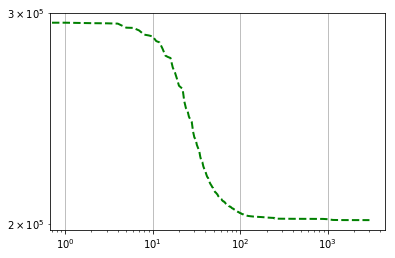

In [38]:
plt.plot(np.arange(len(F)),F,'g--',linewidth=2)
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [39]:
np.diag(C_A)

array([6.32235768, 6.21284613, 6.30186988, 5.77198879, 6.78514697,
       6.56153948, 9.2154033 , 6.16173482, 6.67656103, 6.10845955,
       6.18300497, 6.23260662, 6.88054586, 6.89763703, 9.40744868,
       7.35140986, 6.48161355, 7.55140831, 6.65716802, 8.08265654])

In [40]:
np.diag(C_B)

array([8.94525248, 7.33406094, 6.01355656, 7.59822197, 8.33003936,
       7.60862076, 4.17247148, 7.87182304, 7.83463282, 8.38135525,
       8.41872585, 7.72355552, 6.23750018, 7.4021182 , 4.77704926,
       6.52105238, 8.85049555, 7.0705105 , 8.54172004, 5.7519877 ])

In [41]:
f"sigma_est: {np.sqrt(sigma2):0.2f}" 

'sigma_est: 4.02'